# SWI Invertebrate Analysis
### https://www.tutorialspoint.com/statistics/shannon_wiener_diversity_index.htm

- This is still a WIP based on some subsetting ideas that I could think of
- Suggestions are most welcomed

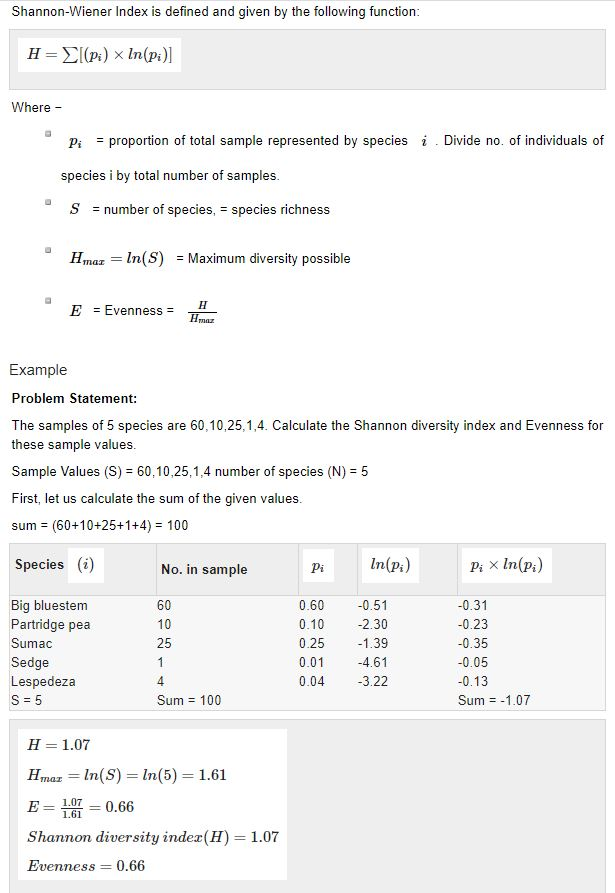

<a id = 'home' ></a>

1. [**Libraries and Analyzing the Data**](#libraries) <a href = '#libraries'></a>
    - No null values
    - No variables with either Single Value or All Unique Values
2. [**Plots**](#plt) <a href = '#plt'></a>   
    - [**Correlation Analysis**](#cor) <a href = '#cor'></a>
        - Some expected outputs:
            - SWI & SWF (0.68)
            - Temperature & Duration (0.87)
    - [**Illustration of which variable could be dropped to analysis based on correlation**](#crdrp) <a href = '#crdrp'></a>           
    - [**Box Plots**](#box) <a href = '#box'></a>
        - Outliers observed for temperature and duration
            - Data subset 1 can be prepared without temperature outliers
            - Data subset 2 can be prepared without duration outliers
        - SWF too has outliers but too far from the thresholds
            - Data subset 3 can be prepared without SWF outliers
    - [**Distribution of SWF**](#swf) <a href = '#swf'></a>
    - [**Distribution of temperature**](#temp) <a href = '#temp'></a>
        - Left-skewness observed 
        - [Applying Box-Cox transformation to temperature](#bct) <a href = '#bct'></a>
    - [**Frequency plot for management**](#mgmt) <a href = '#mgmt'></a>
        - Based on the frequencies:
            - Data subset 4 can be prepared for values = [0, 3, 8]
            - Data subset 5 can be prepared for values = [1, 5, 7]
            - Data subset 6 can be prepared for values = [2, 4, 6]
3. [**Data Preparation**](#dataprep) <a href = '#dataprep'></a>
    - **Checking column/s to change to Categorical**
4. [**Model Building**](#model) <a href = '#model'></a>
    - [**A. Lasso Regression**](#lg) <a href = '#lg'></a>
    - [**B. Linear Regression**](#lr) <a href = '#lr'></a> 
    - [**C. Decision Tree**](#dt) <a href = '#dt'></a> 
    - [**D. Random Forest**](#rf) <a href = '#rf'></a> 

## 1. Libraries and Analyzing the Data <a id = 'libraries' ></a>
[Home](#home) <a href = '#home'></a>

In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
import copy
import math

import sklearn
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import graphviz

In [2]:
invertebrate_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Invertebrate/Invertebrate_dataset.csv')
invertebrate_data.head()

,SWI,SWF,temperature,size,management,duration
0,0.59,1.30,3.5,0.5,2,20
1,1.21,1.85,4.6,47.2,3,19
2,1.08,0.97,4.8,53.3,4,22
3,1.60,1.67,5.2,27.2,8,20
4,2.95,2.41,5.7,38.8,6,22


In [3]:
test_new = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Invertebrate/Invertebrate_new_test_data.csv')
test_new.head()

,SWF,temperature,size,management,duration
0,0.86,21.6,21.6,5,32
1,1.30,21.6,23.7,4,35
2,1.79,21.7,32.9,3,39
3,1.92,21.8,47.5,7,34
4,0.90,21.8,42.8,6,35


In [4]:
print(invertebrate_data.shape)
print(test_new.shape)

(280, 6)
(120, 5)


#### Checking Data Types

In [5]:
invertebrate_data.dtypes

SWI            float64
SWF            float64
temperature    float64
size           float64
management       int64
duration         int64
dtype: object

In [6]:
test_new.dtypes

SWF            float64
temperature    float64
size           float64
management       int64
duration         int64
dtype: object

#### Checking NAs

In [7]:
invertebrate_data.isna().sum()

SWI            0
SWF            0
temperature    0
size           0
management     0
duration       0
dtype: int64

In [8]:
test_new.isna().sum()

SWF            0
temperature    0
size           0
management     0
duration       0
dtype: int64

#### Checking column/s with Single Value or All Unique Values

In [9]:
for i in invertebrate_data.columns:
    if invertebrate_data[i].nunique() == 1:
        print('With only 1 unique value: ', i)
    if invertebrate_data[i].nunique() == invertebrate_data.shape[0]:
        print('With all unique value: ', i)

In [10]:
for i in test_new.columns:
    if test_new[i].nunique() == 1:
        print('With only 1 unique value: ', i)
    if test_new[i].nunique() == test_new.shape[0]:
        print('With all unique value: ', i)

## 2. Plots    <a id = 'plt' ></a>
[Home](#home) <a href = '#home'></a>

#### Correlation Analysis <a id = 'cor' ></a>

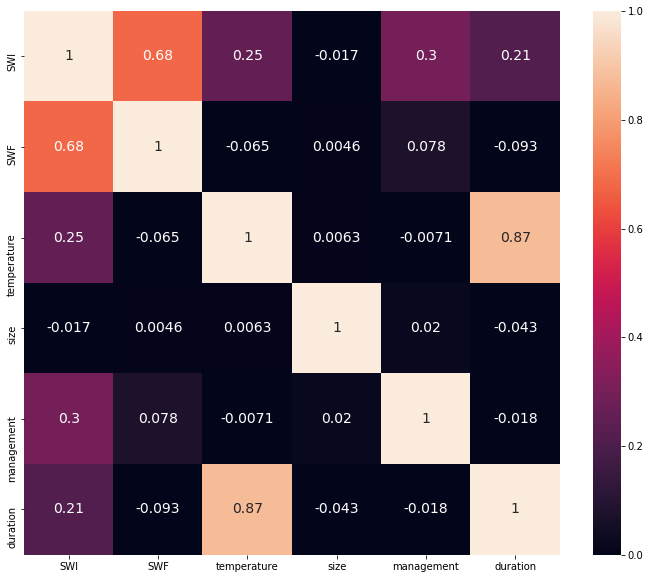

In [11]:
plt.figure(figsize = (12,10))
sns.heatmap(invertebrate_data.corr(), vmin=invertebrate_data.values.min(), vmax=1, 
            annot=True, annot_kws={"size":14}, square = False)
plt.show()

#### Illustration of which variable could be dropped to analys based on correlation <a id = 'crdrp' ></a>
[Home](#home) <a href = '#home'></a>

In [12]:
# Create correlation matrix
corr_matrix = invertebrate_data.corr().abs()
corr_matrix

,SWI,SWF,temperature,size,management,duration
SWI,1.000000,0.680071,0.254698,0.016571,0.300495,0.214081
SWF,0.680071,1.000000,0.065078,0.004630,0.077577,0.093165
temperature,0.254698,0.065078,1.000000,0.006262,0.007137,0.874055
size,0.016571,0.004630,0.006262,1.000000,0.020412,0.043318
management,0.300495,0.077577,0.007137,0.020412,1.000000,0.017970
duration,0.214081,0.093165,0.874055,0.043318,0.017970,1.000000


In [13]:
# Select upper triangle of correlation matrix as lower does not remove the diagonal 1s
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.85
# Just to illustrate taking 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop

['duration']

In [14]:
# Then df with dropped feature/s
# new_df = invertebrate_data.drop(invertebrate_data[to_drop], axis=1)
# new_df.columns

#### Box Plots <a id = 'box' ></a>
[Home](#home) <a href = '#home'></a>

In [15]:
X = invertebrate_data.copy().drop('SWI', axis = 1)
y = invertebrate_data['SWI']

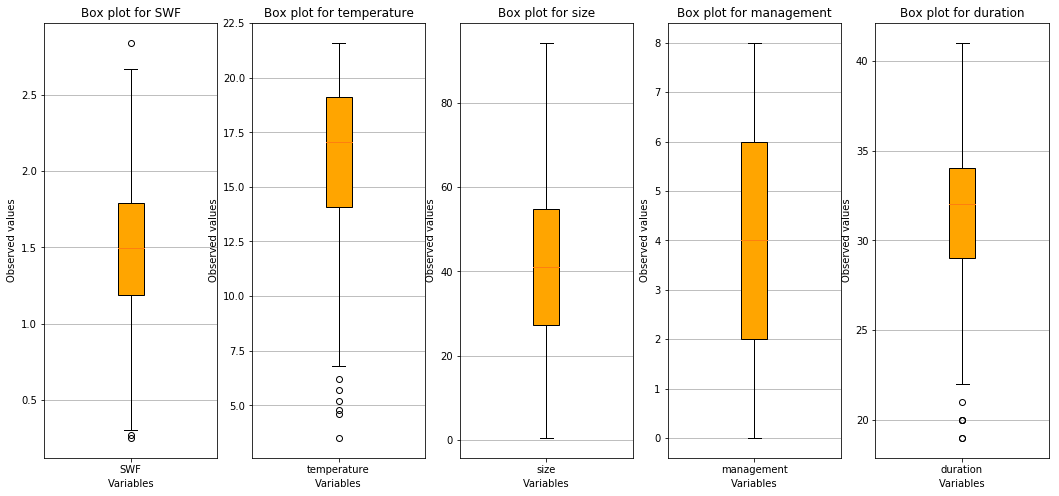

In [16]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(18,8))

label1 = ['SWF']
label2 = ['temperature']
label3 = ['size']
label4 = ['management']
label5 = ['duration']

# Box plot for SWF
bplot1 = ax1.boxplot(X['SWF'],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels = label1)  # will be used to label x-ticks
ax1.set_title('Box plot for SWF')

# Box plot for temperature
bplot2 = ax2.boxplot(X['temperature'],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels = label2)  # will be used to label x-ticks
ax2.set_title('Box plot for temperature')

# Box plot for size
bplot3 = ax3.boxplot(X['size'],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels = label3)  # will be used to label x-ticks
ax3.set_title('Box plot for size')

# Box plot for management
bplot4 = ax4.boxplot(X['management'],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels = label4)  # will be used to label x-ticks
ax4.set_title('Box plot for management')

# Box plot for duration
bplot5 = ax5.boxplot(X['duration'],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels = label5)  # will be used to label x-ticks
ax5.set_title('Box plot for duration')

# Fill with colors
colors = ['orange']
for bplot in (bplot1, bplot2, bplot3, bplot4, bplot5):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# Adding horizontal grid lines
for ax in [ax1, ax2, ax3, ax4, ax5]:
    ax.yaxis.grid(True)
    ax.set_xlabel('Variables')
    ax.set_ylabel('Observed values')

plt.show()

#### Distribution of SWF <a id = 'swf' ></a>
[Home](#home) <a href = '#home'></a>

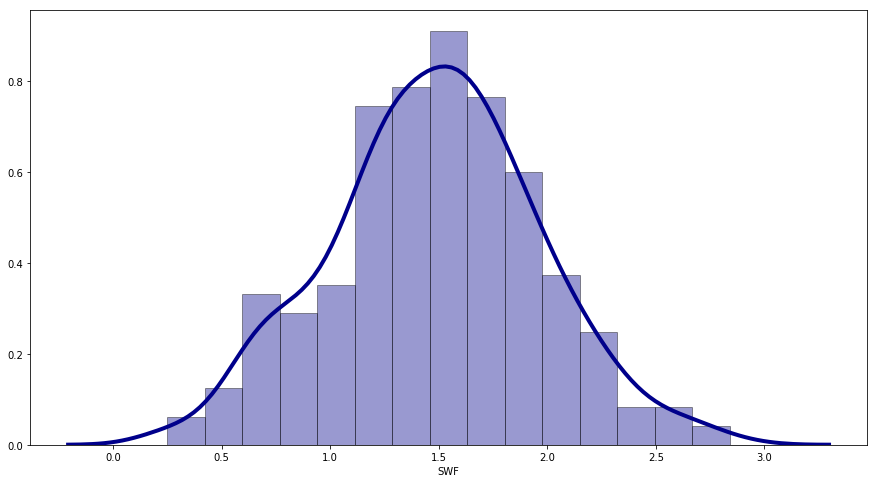

In [17]:
plt.figure(figsize = (15,8))
sns.distplot(X['SWF'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

#### Distribution of temperature <a id = 'temp' ></a>
[Home](#home) <a href = '#home'></a>

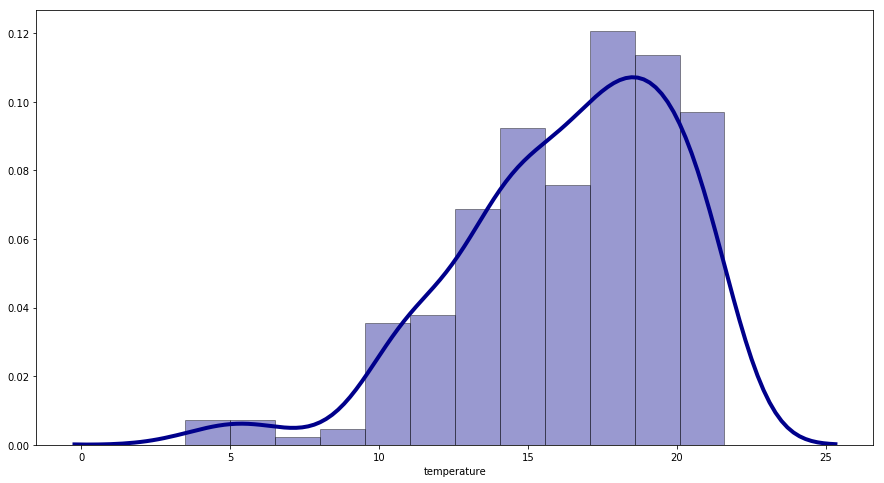

In [18]:
plt.figure(figsize = (15,8))
sns.distplot(X['temperature'], hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

#### Applying Box-Cox transformation to temperature <a id = 'bct' ></a>
[Home](#home) <a href = '#home'></a>

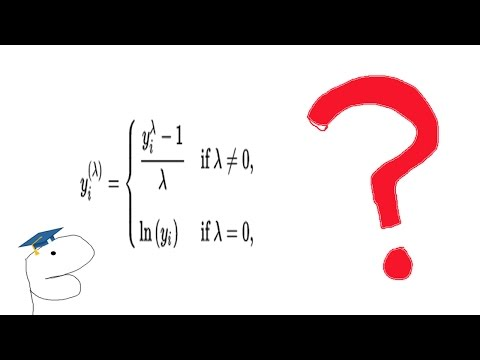

In [19]:
# Helpful video on Box-Cox. I had to watch it several times.

from IPython.display import YouTubeVideo

def display_yotube_video(url, **kwargs):
    """
    Displays a Youtube video in a Jupyter notebook.
    
    Args:
        url (string): a link to a Youtube video.
        **kwargs: further arguments for IPython.display.YouTubeVideo
    
    Returns:
        YouTubeVideo: a video that is displayed in your notebook.
    """
    id_ = url.split("=")[-1]
    return YouTubeVideo(id_, **kwargs)

display_yotube_video("https://www.youtube.com/watch?v=2gVA3TudAXI", width=600, height=400)

In [20]:
X_norm = X.copy()

# Transform training data & save lambda value
X_norm['temperature'], fitted_lambda = stats.boxcox(X_norm['temperature'])
print('Skewness before: ', X['temperature'].skew())
print('Skewness after BCT: ', X_norm['temperature'].skew())

Skewness before:  -0.8390764441117718
Skewness after BCT:  -0.18048218383312165


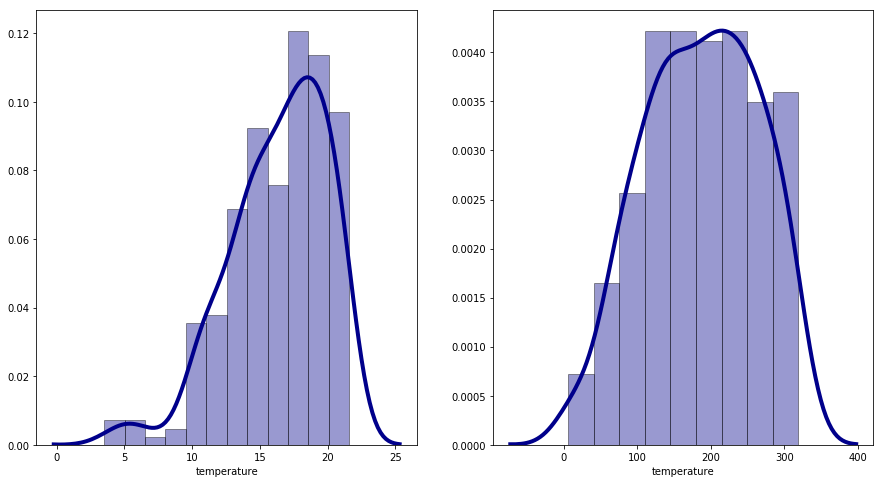

In [21]:
fig, ax=plt.subplots(1,2, figsize = (15,8))
sns.distplot(X['temperature'], hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4}, ax=ax[0])
sns.distplot(X_norm['temperature'], hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4}, ax=ax[1])

In [22]:
test_norm = test_new.copy()
# Use lambda value to transform test data
test_norm['temperature'] = stats.boxcox(test_new['temperature'], fitted_lambda)
print('Skewness before: ', test_new['temperature'].skew())
print('Skewness after BCT: ', test_norm['temperature'].skew())

Skewness before:  1.0501744071754524
Skewness after BCT:  1.3551621176708242


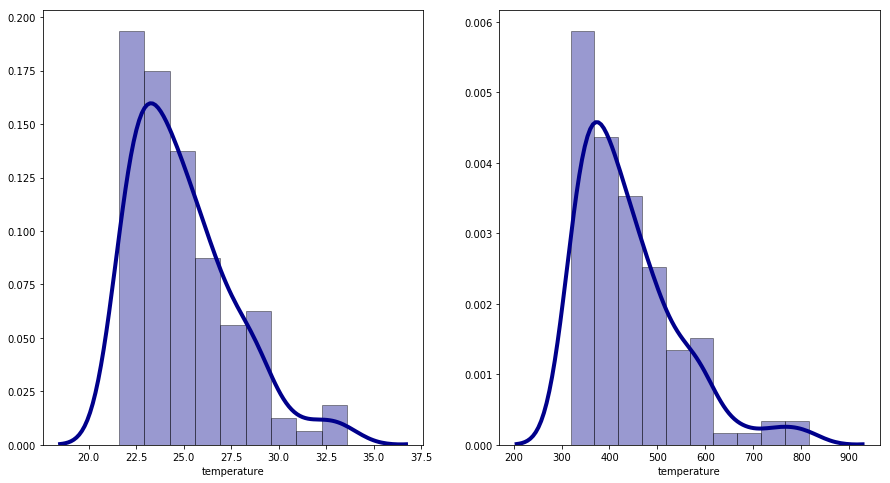

In [23]:
fig, ax=plt.subplots(1,2, figsize = (15,8))
sns.distplot(test_new['temperature'], hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4}, ax=ax[0])
sns.distplot(test_norm['temperature'], hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4}, ax=ax[1])

#### Frequency plot for management <a id = 'mgmt' ></a>
[Home](#home) <a href = '#home'></a>

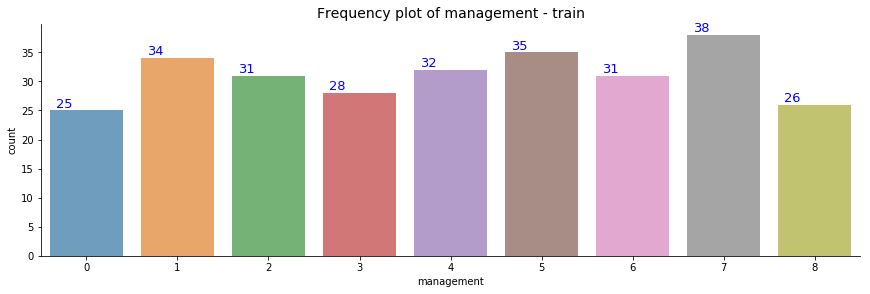

In [24]:
sns.catplot('management', data= invertebrate_data, kind='count', alpha=0.7, height=4, aspect= 3)

# Get current axis on current figure
ax = plt.gca()

# Max value to be set
y_max = invertebrate_data['management'].value_counts().max() 

# Iterate through the list of axes' patches
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/5., p.get_height(),'%d' % int(p.get_height()),
            fontsize=13, color='blue', ha='center', va='bottom')
plt.title('Frequency plot of management - train', fontsize = 14, color = 'black')
plt.show()

## 3. Data Preparation <a id = 'dataprep' ></a>
[Home](#home) <a href = '#home'></a>

#### Checking column/s to change to Categorical

In [25]:
print('For Train')
d1 = X_norm.nunique()
print(sorted(d1))
print("==============================")
print('For Test')
d2 = test_norm.nunique()
print(sorted(d2))

For Train
[9, 21, 113, 144, 220]
For Test
[9, 19, 63, 88, 113]


In [26]:
col_train = X_norm.columns
col_test = test_norm.columns

In [27]:
l1 = []
for i in col_train:
    if X_norm[i].nunique() <= 22:
        l1.append(i)

In [28]:
l2 = []
for i in col_test:
    if test_norm[i].nunique() <= 22:
        l2.append(i)

In [29]:
# Checking the columns in train and test are same or not
df = pd.DataFrame(l1, columns = ['train'])
df['test'] = pd.DataFrame(l2)
df

,train,test
0,management,management
1,duration,duration


In [30]:
# For now directly changing management to categorical without creating subsets
X_norm[l1] = X_norm[l1].apply(lambda x: x.astype('category'), axis=0)
test_norm[l2] = test_norm[l2].apply(lambda x: x.astype('category'), axis=0)
print('train dtypes:')
print(X_norm[l1].dtypes)
print('======================================')
print('test dtypes:')
print(test_norm[l1].dtypes)

train dtypes:
management    category
duration      category
dtype: object
test dtypes:
management    category
duration      category
dtype: object


#### Function to create dummies for cat vars

In [31]:
l1

['management', 'duration']

In [32]:
# Function to create dummies
def dummy(train, test, cols):
    X_num = len(train)
    combined_dataset = pd.concat(objs=[train, test], axis=0)
    combined_dataset = pd.get_dummies(combined_dataset, columns=cols, drop_first=True)
    train = copy.copy(combined_dataset[:X_num])
    test = copy.copy(combined_dataset[X_num:])

In [33]:
dummy(X, test_new, l1)
X_num = len(X)
combined_dataset = pd.concat(objs=[X, test_new], axis=0)
combined_dataset = pd.get_dummies(combined_dataset, columns=l1, drop_first=True)
X = copy.copy(combined_dataset[:X_num])
test = copy.copy(combined_dataset[X_num:])

In [34]:
print(X.shape)
print(y.shape)
print(test.shape)

(280, 35)
(280,)
(120, 35)


In [35]:
dummy(X_norm, test_norm, l1)
X_norm_num = len(X_norm)
combined_dataset_norm = pd.concat(objs=[X_norm, test_norm], axis=0)
combined_dataset_norm = pd.get_dummies(combined_dataset_norm, columns=l1, drop_first=True)
X_norm = copy.copy(combined_dataset_norm[:X_norm_num])
test_norm = copy.copy(combined_dataset_norm[X_norm_num:])

In [36]:
print(X_norm.shape)
print(y.shape)
print(test_norm.shape)

(280, 35)
(280,)
(120, 35)


## 3. Model Building <a id = 'model' ></a>

[Home](#home) <a href = '#home'></a>

#### Splitting of data into train and validation sets

In [37]:
# Splitting into train and validation sets for non BCT (Box-Cox Transformed) data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 50)

In [38]:
# Splitting into train and validation sets for BCT data
X_train_bct, X_val_bct, y_train_bct, y_val_bct = train_test_split(X_norm, y, test_size=0.2, random_state = 50)

### A. Lasso Regression <a id = 'lg' ></a>

[Home](#home) <a href = '#home'></a>

In [90]:
print('On non BCT data')
print('---------------')
lasso_reg = LassoCV(cv=5, random_state=1)
lasso_reg.fit(X_train, y_train)
print("Best alpha using built-in LassoCV: %f" % lasso_reg.alpha_)
print("Best score using built-in LassoCV: %f" % lasso_reg.score(X_train,y_train))
coef = pd.Series(lasso_reg.coef_, index = X_train.columns)

On non BCT data
---------------
Best alpha using built-in LassoCV: 0.002304
Best score using built-in LassoCV: 0.642384


In [91]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 22 variables and eliminated the other 13 variables


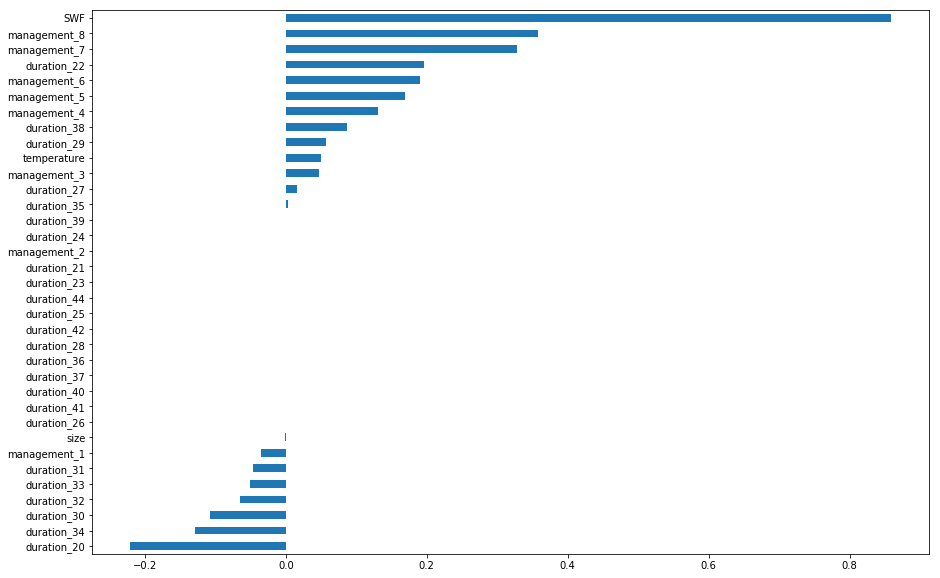

In [92]:
# Important features
imp_coef = coef.sort_values()
ax1 = imp_coef.plot(kind = "barh" )
plt.rcParams['figure.figsize'] = (15.0, 10.0)

In [93]:
print('On BCT data')
print('---------------')
lasso_reg_norm = LassoCV(cv=5, random_state=1)
lasso_reg_norm.fit(X_train_bct, y_train_bct)
print("Best alpha using built-in LassoCV: %f" % lasso_reg_norm.alpha_)
print("Best score using built-in LassoCV: %f" % lasso_reg_norm.score(X_train_bct,y_train_bct))
coef_norm = pd.Series(lasso_reg_norm.coef_, index = X_train_bct.columns)

On BCT data
---------------
Best alpha using built-in LassoCV: 0.012341
Best score using built-in LassoCV: 0.589961


In [94]:
print("Lasso picked " + str(sum(coef_norm != 0)) + " variables and eliminated the other " +  
      str(sum(coef_norm == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 28 variables


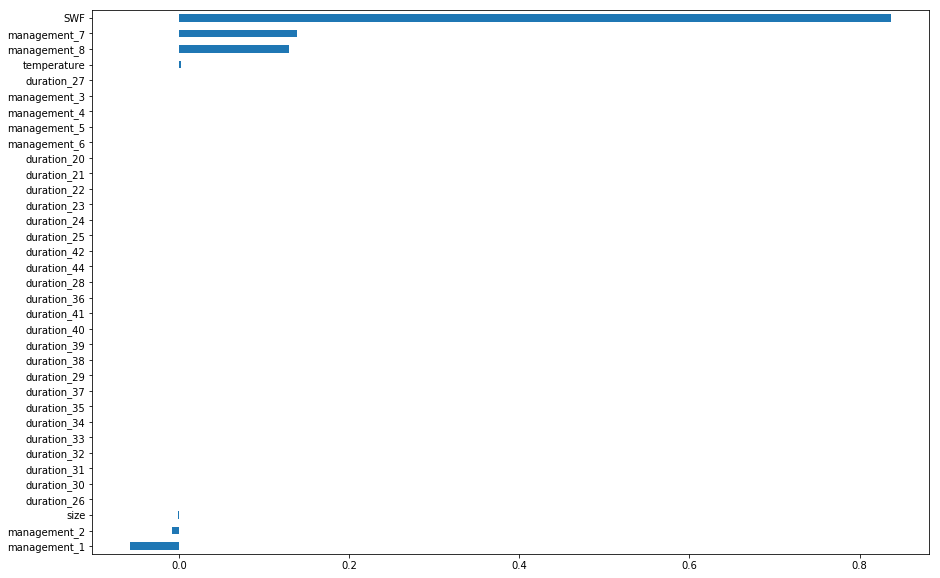

In [95]:
# Important features
imp_coef_norm = coef_norm.sort_values()
ax1 = imp_coef_norm.plot(kind = "barh" )
plt.rcParams['figure.figsize'] = (15.0, 10.0)

In [96]:
# Predict (train)
y_train_pred = lasso_reg.predict(X_train)

# Model evaluation
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.6423843567028341
MSE:  0.13787852881626145
RMSE:  0.371319981708851


In [97]:
# Predict (val)
y_val_pred = lasso_reg.predict(X_val)

# Model evaluation (val)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.5126758922358706
MSE:  0.14601523169307384
RMSE:  0.38211939455237526


In [98]:
# Predict (train)
y_train_pred_bct = lasso_reg_norm.predict(X_train_bct)

# Model evaluation
mse = mean_squared_error(y_train_bct, y_train_pred_bct)
r2 = r2_score(y_train_bct, y_train_pred_bct)
rmse = math.sqrt(mse)
print('On BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On BCT data
----------------
R-squared:  0.5899607554073925
MSE:  0.15809042154898362
RMSE:  0.3976058620656688


In [100]:
# Predict (val)
y_val_pred_bct = lasso_reg_norm.predict(X_val_bct)

# Model evaluation (val)
mse = mean_squared_error(y_val_bct, y_val_pred_bct)
r2 = r2_score(y_val_bct, y_val_pred_bct)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.46257989979546965
MSE:  0.16102532010556844
RMSE:  0.40127960340088115


### B. Linear Regression <a id = 'lr' ></a>

[Home](#home) <a href = '#home'></a>

In [102]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [103]:
# Predict (train)
y_train_pred = linreg.predict(X_train)

# Model evaluation (train)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.6542865397066386
MSE:  0.13328964823168696
RMSE:  0.3650885484806213


In [105]:
# Predict (val)
y_val_pred = linreg.predict(X_val)

# Model evaluation (val)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.4833199458623316
MSE:  0.15481105205781645
RMSE:  0.3934603563992394


In [106]:
linreg_bct = LinearRegression()
linreg_bct.fit(X_train_bct, y_train_bct)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [107]:
# Predict (train)
y_train_pred_bct = linreg_bct.predict(X_train_bct)

# Model evaluation
mse = mean_squared_error(y_train_bct, y_train_pred_bct)
r2 = r2_score(y_train_bct, y_train_pred_bct)
rmse = math.sqrt(mse)
print('On BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On BCT data
----------------
R-squared:  0.6532102979351049
MSE:  0.13370459269759885
RMSE:  0.3656563861025797


In [109]:
# Predict (val)
y_val_pred_bct = linreg_bct.predict(X_val_bct)

# Model evaluation (val)
mse = mean_squared_error(y_val_bct, y_val_pred_bct)
r2 = r2_score(y_val_bct, y_val_pred_bct)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.4817683552908627
MSE:  0.15527594975767633
RMSE:  0.3940506944007031


### C. Decision Tree <a id = 'dt' ></a>

[Home](#home) <a href = '#home'></a>

In [ ]:
# You can try by removing the max_depth and see the output for Predict (train)

In [142]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=50, max_depth=4)
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=50, splitter='best')

In [143]:
# Predict (train)
y_train_pred = dt.predict(X_train)

# Model evaluation (train)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.6762685251942651
MSE:  0.12481450494223134
RMSE:  0.3532909635728479


In [144]:
# Predict (val)
y_val_pred = dt.predict(X_val)

# Model evaluation (val)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.21324413309711754
MSE:  0.23573293083893976
RMSE:  0.48552335766566346


### D. Random Forest <a id = 'rf' ></a>

[Home](#home) <a href = '#home'></a>

In [110]:
from sklearn.ensemble import RandomForestRegressor
rf1 = RandomForestRegressor()
rf1.fit(X = X_train,y = y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [112]:
# Predict (train)
y_train_pred_rf = rf1.predict(X_train)

# Model evaluation (train)
mse = mean_squared_error(y_train, y_train_pred_rf)
r2 = r2_score(y_train, y_train_pred_rf)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.9084254003363871
MSE:  0.03530654017857143
RMSE:  0.18790034640354294


In [113]:
# Predict (val)
y_val_pred_rf = rf1.predict(X_val)

# Model evaluation (val)
mse = mean_squared_error(y_val, y_val_pred_rf)
r2 = r2_score(y_val, y_val_pred_rf)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.42429199275288276
MSE:  0.17249739285714288
RMSE:  0.41532805450287474


#### Grid Search and CV <a id = 'gs' ></a>

[Home](#home) <a href = '#home'></a>

In [116]:
rfgs = RandomForestRegressor(random_state=50)

In [119]:
param_grid = { 
    'n_estimators': [2,3,4,5],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,3,4,5],
    'criterion' :['mse']
}

In [120]:
cv_rfc = GridSearchCV(estimator=rfgs, param_grid=param_grid, cv= 5)
cv_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=50, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [2, 3, 4, 5], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 3, 4, 5], 'criterion': ['mse']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [121]:
cv_rfc.best_params_

{'criterion': 'mse', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 5}

In [125]:
rfgs1 = RandomForestRegressor(random_state=45, **cv_rfc.best_params_)

In [126]:
rfgs1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
           oob_score=False, random_state=45, verbose=0, warm_start=False)

In [127]:
# Predict (train)
y_train_pred_rf = rfgs1.predict(X_train)

# Model evaluation (train)
mse = mean_squared_error(y_train, y_train_pred_rf)
r2 = r2_score(y_train, y_train_pred_rf)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.6239976046411569
MSE:  0.14496753169264512
RMSE:  0.38074601993014334


In [128]:
# Predict (val)
y_val_pred_rf = rfgs1.predict(X_val)

# Model evaluation (val)
mse = mean_squared_error(y_val, y_val_pred_rf)
r2 = r2_score(y_val, y_val_pred_rf)
rmse = math.sqrt(mse)
print('On non BCT data')
print('----------------')
print('R-squared: ', r2)
print('MSE: ', mse)
print('RMSE: ', rmse)

On non BCT data
----------------
R-squared:  0.42830034606586465
MSE:  0.171296383860506
RMSE:  0.41387967316661733
